In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(2023)

## Dataset

In [3]:
class ToyDataset(Dataset):
    def __init__(self):
        self.x = torch.cat([
            torch.randn((300, 1)) * 0.1 + 0.6,
            torch.randn((700, 1)) * 0.05 - 0.4,
        ])
        self.x.clamp_(-1, 1)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        return self.x[item]

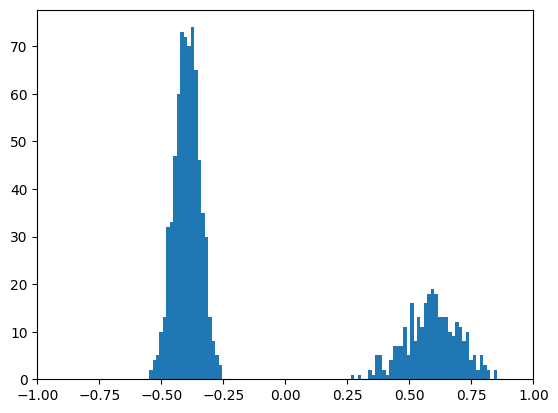

In [4]:
dataset = ToyDataset()
plt.hist(dataset.x[:, 0], bins=100)
plt.xlim(-1, 1)
plt.show()

## Model

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, 10),
            nn.LeakyReLU(0.2),
            nn.Linear(10, 50),
            nn.LeakyReLU(0.2),
            nn.Linear(50, 10),
            nn.LeakyReLU(0.2),
            nn.Linear(10, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [6]:
model = MLP()
model_copy = MLP().requires_grad_(False)

## Training

In [7]:
lr = 0.005
batch_size = 1000
n_epochs = 100

In [8]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

In [9]:
losses = []
for ep in range(n_epochs):
    for i, x in enumerate(dataloader):
        z = torch.randn_like(x)
        
        # apply f
        model_copy.load_state_dict(model.state_dict())
        fx = model(x)
        fz = model(z)
        f_z = fz.detach()
        ff_z = model(f_z)
        f_fz = model_copy(fz)
        
        # reconstruction loss
        loss_rec = mse(fx, x)
        # idempoence loss
        loss_idem = mse(f_fz, fz)
        # tightening loss
        loss_tight = -mse(ff_z, f_z)
        # total loss
        loss = loss_rec + loss_idem + loss_tight * 0.1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == len(dataloader) - 1:
            losses.append(loss.item())
            print(f'Epoch {ep}: '
                  f'loss={loss.item():.3f}, '
                  f'loss_rec={loss_rec.item():.3f}, '
                  f'loss_idem={loss_idem.item():.3f}, '
                  f'loss_tight={loss_tight.item():.3f}')

Epoch 0: loss=0.204, loss_rec=0.204, loss_idem=0.000, loss_tight=-0.000
Epoch 1: loss=0.184, loss_rec=0.183, loss_idem=0.001, loss_tight=-0.001
Epoch 2: loss=0.169, loss_rec=0.166, loss_idem=0.004, loss_tight=-0.004
Epoch 3: loss=0.157, loss_rec=0.150, loss_idem=0.008, loss_tight=-0.008
Epoch 4: loss=0.146, loss_rec=0.136, loss_idem=0.011, loss_tight=-0.011
Epoch 5: loss=0.137, loss_rec=0.123, loss_idem=0.015, loss_tight=-0.015
Epoch 6: loss=0.129, loss_rec=0.112, loss_idem=0.018, loss_tight=-0.018
Epoch 7: loss=0.123, loss_rec=0.103, loss_idem=0.023, loss_tight=-0.023
Epoch 8: loss=0.116, loss_rec=0.093, loss_idem=0.025, loss_tight=-0.025
Epoch 9: loss=0.107, loss_rec=0.084, loss_idem=0.026, loss_tight=-0.026
Epoch 10: loss=0.095, loss_rec=0.074, loss_idem=0.024, loss_tight=-0.024
Epoch 11: loss=0.083, loss_rec=0.065, loss_idem=0.021, loss_tight=-0.021
Epoch 12: loss=0.071, loss_rec=0.056, loss_idem=0.016, loss_tight=-0.016
Epoch 13: loss=0.061, loss_rec=0.048, loss_idem=0.015, loss_t

## Sample

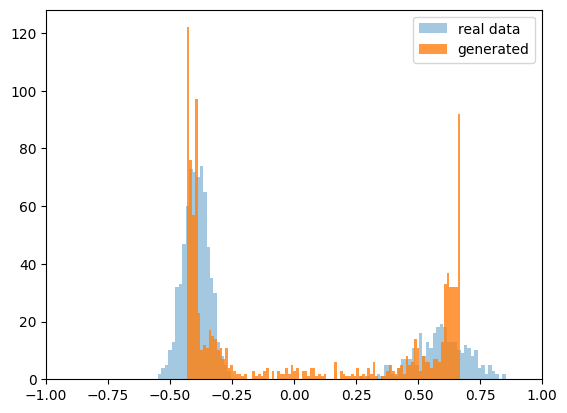

In [10]:
z = torch.randn(1000, 1)
x = model(z).detach()
plt.hist(dataset.x[:, 0], bins=100, alpha=0.4, label='real data')
plt.hist(x[:, 0], bins=100, alpha=0.8, label='generated')
plt.xlim(-1, 1)
plt.legend()
plt.show()

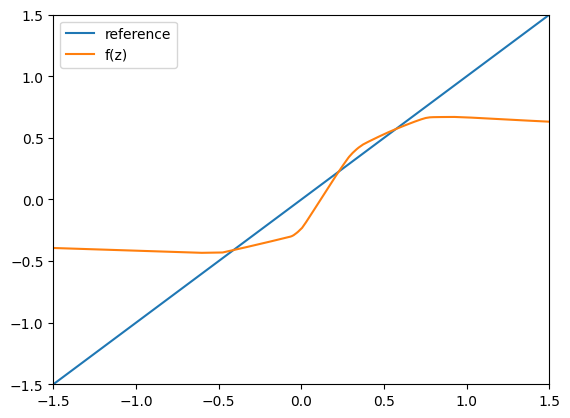

In [11]:
z = torch.linspace(-1.5, 1.5, 1000).unsqueeze(1)
x = model(z).detach()
plt.plot(z[:, 0], z[:, 0], label='reference')
plt.plot(z[:, 0], x[:, 0], label='f(z)')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()